# The Swedish parliament and gender balance (draft)

I stumbled over a news article on the gender balance in the Swedish parliament that made some statements 
about the fairness of the current and past gender balance. It made me wonder how fairness should be defined.
Having 161 women and 188 men in parliament is a $161/349 \approx 0.46$, i.e. well inside the 60/40 rule 
of thumb. However, is there a way to talk about gender balance in terms of statistical significance.

Note: I'm doing this for fun and as an example of statistics. I make no claim that this is a good model
of reality. Remember from an earlier lecture, "all models are wrong, but some are usefull".

https://www.svt.se/nyheter/inrikes/mp-och-kd-mest-ojamstallda-i-riksdagen

First we need to load some modules and configure plotting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom, binom_test

# The following line is only needed in jupyter notebook (i.e. here), not when doning this from command line.
%matplotlib inline

Now for loading the data from a CSV (comma separated values) file. 

In [2]:
colours = dict()
party_name = dict()
party = list()
data = np.zeros((8, 4)) # party, 
with open("gender_balance_riksdagen.csv", 'r', errors='ignore') as f:
    f.readline()
    f.readline()
    for p in range(8):
        textline = [e.strip() for e in f.readline().split(",")]
        key = textline[1]
        party.append(key)
        party_name[key] = textline[0]
        colours[key] = textline[2]
        data[p, :] = [int(n) for n in textline[3:]]

print(party)
print(party_name)
print(colours)
print(data)

['S', 'C', 'KD', 'L', 'MP', 'M', 'SD', 'V']
{'S': 'Socialdemokraterna', 'C': 'Centerpartiet', 'KD': 'Kristdemokraterna', 'L': 'Liberalerna', 'MP': 'Miljpartiet', 'M': 'Moderaterna', 'SD': 'Sverigedemokraterna', 'V': 'Vnsterpartiet'}
{'S': 'Red', 'C': 'DarkGreen', 'KD': 'Blue', 'L': 'LightBlue', 'MP': 'LightGreen', 'M': 'DarkBlue', 'SD': 'Yellow', 'V': 'DarkRed'}
[[48. 52. 53. 60.]
 [12. 19.  9. 13.]
 [ 6. 16.  6. 10.]
 [ 8. 12.  5. 14.]
 [12.  4. 12. 13.]
 [38. 32. 44. 40.]
 [18. 44. 12. 37.]
 [19.  9. 12.  9.]]


Assumptions...

For sake of argument, I will approximate gender as a binary model. If I don't do this approximation, the
distribution of gender can't be modelled as a binomial distribution and loses its value from me as a teacher.
This is a crucial point. All models are approximations of reality. No model is correct, however, some 
are usefull.

$H_0$: Equality

$H_a$: Partiarchy


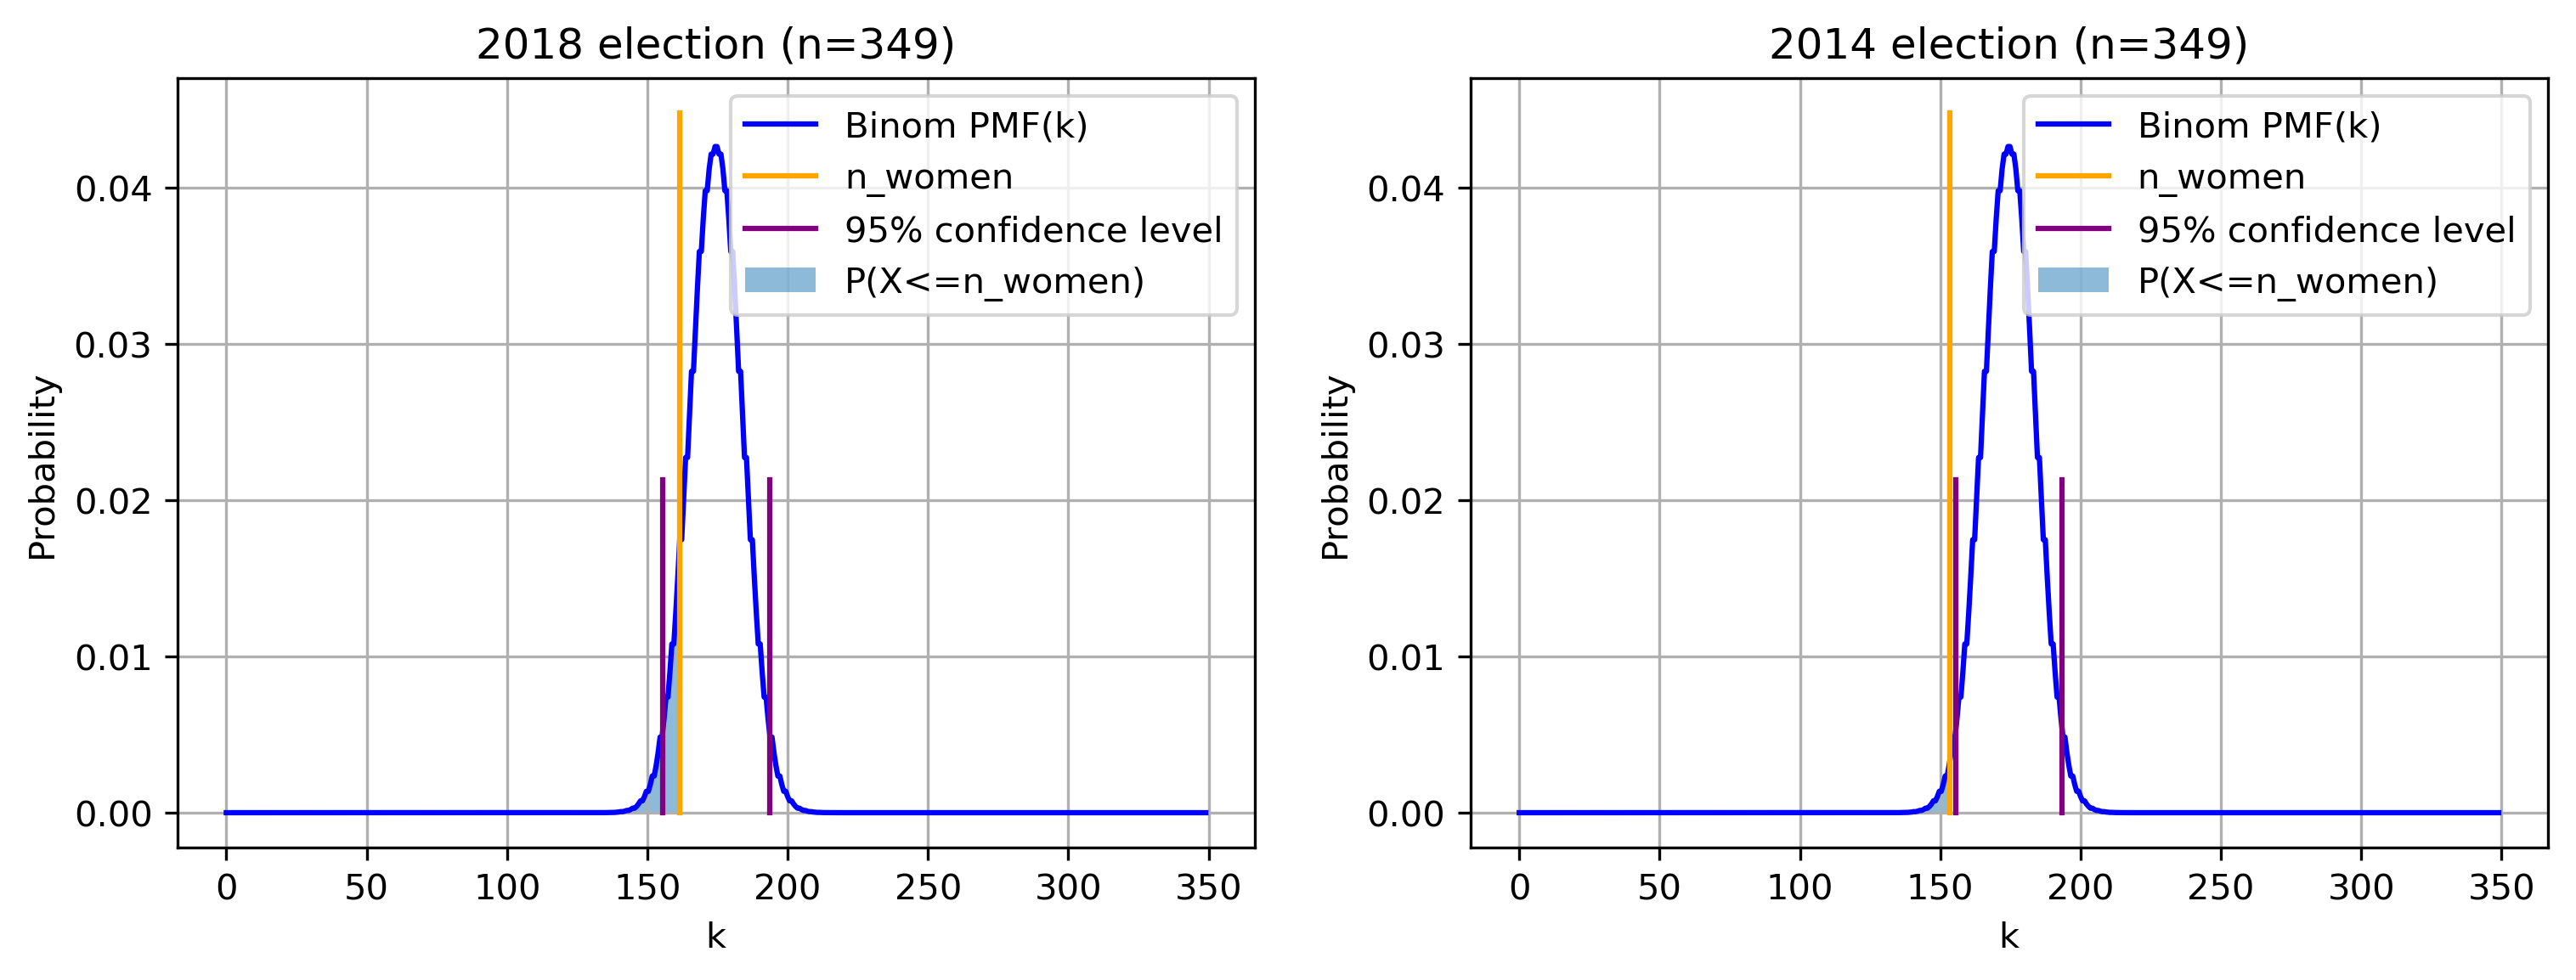

In [3]:
p = 1/2
alpha = .05

n18 = int(np.sum(data[:, :2]))
n14 = int(np.sum(data[:, 2:]))
n_women18 = int(np.sum(data[:, 0]))
n_women14 = int(np.sum(data[:, 2]))

assert n14 == 349
assert n18 == 349
assert 0 <= p and p <= 1, "p must be a probability"

binom14 = binom(n=n14, p=p)
binom18 = binom(n=n18, p=p)
k = np.arange(349+1)

fig = plt.figure(figsize=(12, 4), dpi=300)
ax = fig.subplots(1, 2)
x = np.linspace(np.min(k), np.max(k), 500)

y = binom18.pmf(np.round(x))
ax[0].plot(x, y, 'b', label="Binom PMF(k)")
if n_women14 <= np.max(x):
    ax[0].plot([n_women18+.5, n_women18+.5], [0, np.max(y)*1.05], 'orange', label="n_women")
fillmask = x<=(n_women18+.5)
ax[0].fill_between(x[fillmask], y[fillmask], alpha=.5, label="P(X<=n_women)")
interval = binom18.interval(1 - alpha)
ax[0].plot([interval[0]-.5, interval[0]-.5], [0, np.max(y)*.5], 'purple', label="%i%% confidence level" % int((1-alpha)*100))
ax[0].plot([interval[1]+.5, interval[1]+.5], [0, np.max(y)*.5], 'purple')
ax[0].legend()
ax[0].set_ylabel("Probability")
ax[0].set_xlabel("k")
ax[0].set_title("2018 election (n=%i)" % n18)
ax[0].grid()

y = binom14.pmf(np.round(x))
ax[1].plot(x, y, 'b', label="Binom PMF(k)")
if n_women14 <= np.max(x):
    ax[1].plot([n_women14+.5, n_women14+.5], [0, np.max(y)*1.05], 'orange', label="n_women")
fillmask = x<=(n_women14+.5)
ax[1].fill_between(x[fillmask], y[fillmask], alpha=.5, label="P(X<=n_women)")
interval = binom14.interval(1 - alpha)
ax[1].plot([interval[0]-.5, interval[0]-.5], [0, np.max(y)*.5], 'purple', label="%i%% confidence level" % int((1-alpha)*100))
ax[1].plot([interval[1]+.5, interval[1]+.5], [0, np.max(y)*.5], 'purple')
ax[1].legend()
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("k")
ax[1].set_title("2014 election (n=%i)" % n14)
ax[1].grid()

Significance testing of the data from above. 

In [4]:
alphas = [0.10, 0.05, 0.01]

def find_one_sided_interval(distribution, alpha):
    n = distribution.kwds['n']
    k = np.arange(n+1)
    s = np.cumsum(distribution.pmf(k))
    for i in range(1, len(s)):
        if alpha <= s[i]:
            return (i-1, n)

print("2018 election")
print("Binom(n=%i, p=%.2f)" % (n18, p))
print("P(X<=%i)=%.3f (p-value)" % (n_women18, np.sum([binom18.pmf(k) for k in range(0, n_women18+1)])))
for alpha in alphas:
    interval = find_one_sided_interval(binom18, alpha)
    print("One sided %i%% confidence level is in the range [%i, %i]" % ((1-alpha)*100, interval[0], interval[1]), end="")
    if interval[0] > n_women18:
        print(" <-- significant")
    else:
        print()
for alpha in alphas:
    interval = binom18.interval(1-alpha)
    print("Two sided %i%% confidence level is in the range [%i, %i]" % ((1-alpha)*100, interval[0], interval[1]), end="")
    if interval[0] > n_women18:
        print(" <-- significant")
    else:
        print()
print()
print("2014 election")
print("Binom(n=%i, p=%.2f)" % (n14, p))
print("P(X<=%i)=%.3f (p-value)" % (n_women14, np.sum([binom14.pmf(k) for k in range(0, n_women14+1)])))
for alpha in alphas:
    interval = find_one_sided_interval(binom14, alpha)
    print("One sided %i%% confidence level is in the range [%i, %i]" % ((1-alpha)*100, interval[0], interval[1]), end="")
    if interval[0] > n_women14:
        print(" <-- significant")
    else:
        print()
for alpha in alphas:
    interval = binom14.interval(1-alpha)
    print("Two sided %i%% confidence level is in the range [%i, %i]" % ((1-alpha)*100, interval[0], interval[1]), end="")
    if interval[0] > n_women14:
        print(" <-- significant")
    else:
        print()

2018 election
Binom(n=349, p=0.50)
P(X<=161)=0.082 (p-value)
One sided 90% confidence level is in the range [162, 349] <-- significant
One sided 95% confidence level is in the range [158, 349]
One sided 99% confidence level is in the range [152, 349]
Two sided 90% confidence level is in the range [159, 190]
Two sided 95% confidence level is in the range [156, 193]
Two sided 99% confidence level is in the range [150, 199]

2014 election
Binom(n=349, p=0.50)
P(X<=153)=0.012 (p-value)
One sided 90% confidence level is in the range [162, 349] <-- significant
One sided 95% confidence level is in the range [158, 349] <-- significant
One sided 99% confidence level is in the range [152, 349]
Two sided 90% confidence level is in the range [159, 190] <-- significant
Two sided 95% confidence level is in the range [156, 193] <-- significant
Two sided 99% confidence level is in the range [150, 199]


What if we model gender proportions in groups of different sizes as binomial distributions? By varying 
the number of people in the groups $n$, given a constant confidence level (with $\alpha=.05$), a non-significant
interval can be calculated. We can compare this to the 60/40 rule of thumb often used. For lower $n$, 
the 60/40 rule gives a smaller interval than what we would get from chance. For a higher $n$, the interval
from chance is narrower than the 60/40 rule. For a 95% confidence level, the 60/40 rule works best around 
a group size of about 80-100 (i.e. not in any single company/department board or the Swedish parliament). 
Note that any proportion outside the binomial interval show, under the model, statistical significance for unfairness.

Best fit is within [81, 98]


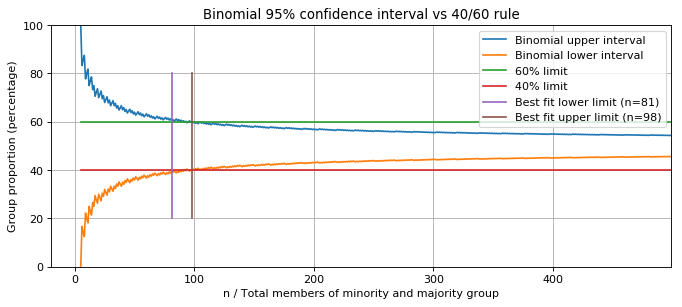

In [5]:
alpha = .05

N = np.arange(5, 500)
intervals = [binom(n=n, p=.5).interval(1-alpha)/n for n in N]
lower = [interval[0]*100 for interval in intervals]
upper = [interval[1]*100 for interval in intervals]
limit = (np.min(N[np.asarray(upper)-60-.5 < 0]), np.max(N[np.asarray(upper)-60 > 0]))

fig = plt.figure(figsize=(10, 4), dpi=80)
ax = fig.subplots(1, 1)
ax.set_title("Binomial %i%% confidence interval vs 40/60 rule" % ((1-alpha)*100))
ax.plot(N, upper, label="Binomial upper interval")
ax.plot(N, lower, label="Binomial lower interval")
ax.plot([np.min(N), np.max(N)], [60, 60], label="60% limit")
ax.plot([np.min(N), np.max(N)], [40, 40], label="40% limit")
ax.plot([limit[0], limit[0]], [20, 80], label="Best fit lower limit (n=%i)" % limit[0])
ax.plot([limit[1], limit[1]], [20, 80], label="Best fit upper limit (n=%i)" % limit[1])
a = list(ax.axis())
a[1] = np.max(N)
a[2] = 0
a[3] = 100
ax.axis(tuple(a))
ax.set_xlabel("n / Total members of minority and majority group")
ax.set_ylabel("Group proportion (percentage)")
ax.legend()
ax.grid()

print("Best fit is within [%i, %i]" % limit)

Two/one sided binomial test for uneven representation.

Note that this could also be seen as an example of p-hacking. With a confidence level of 95%, we will
, sooner or later, find a group with random data that has a significant result with probability 
$1-(1-\alpha)^m$ (remembering our event trees, what is the probability of at least one positive result in $m$ 
number of binary events with success probability $\alpha$).

Socialdemokraterna
n=100, n_women=48, Two-sided non-significant interval: [40, 60]
Two-sided test p-value:	0.764
Less test p-value:	0.382
Greater test p-value:	0.691

Centerpartiet
n=31, n_women=12, Two-sided non-significant interval: [10, 21]
Two-sided test p-value:	0.281
Less test p-value:	0.141
Greater test p-value:	0.925

Kristdemokraterna
n=22, n_women=6, Two-sided non-significant interval: [6, 16]
Two-sided test p-value:	0.052
Less test p-value:	0.026	<-- significant
Greater test p-value:	0.992

Liberalerna
n=20, n_women=8, Two-sided non-significant interval: [6, 14]
Two-sided test p-value:	0.503
Less test p-value:	0.252
Greater test p-value:	0.868

Miljpartiet
n=16, n_women=12, Two-sided non-significant interval: [4, 12]
Two-sided test p-value:	0.077
Less test p-value:	0.989
Greater test p-value:	0.038	<-- significant

Moderaterna
n=70, n_women=38, Two-sided non-significant interval: [27, 43]
Two-sided test p-value:	0.550
Less test p-value:	0.799
Greater test p-value:	0.275

Sve

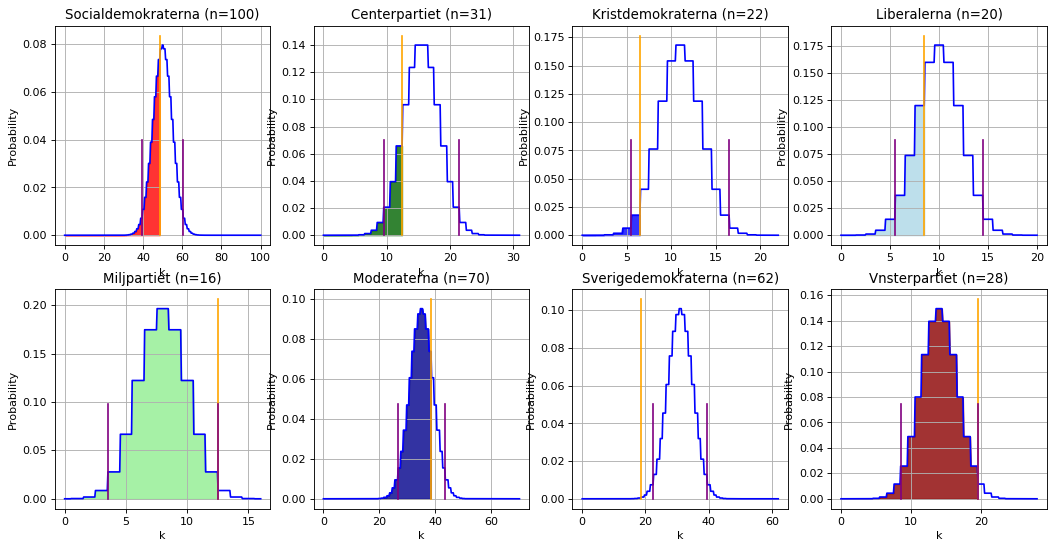

In [6]:
alpha = .05
p = 1/2

fig = plt.figure(figsize=(16, 8), dpi=80)
ax = fig.subplots(2, 4).ravel()

for i, abbr in enumerate(party):
    # 2018 data
    n = np.sum(data[i, :2])
    n_women = data[i, 0]
    # 2014 data
    #n = np.sum(data[i, 2:])
    #n_women = data[i, 2]
    k = np.arange(n+1)
    d = binom(n=n, p=p)
    x = np.linspace(np.min(k), np.max(k), 300)
    y = d.pmf(np.round(x))

    ax[i].plot(x, y, 'b', label="Binom PMF(k)")
    if n_women <= np.max(x):
        ax[i].plot([n_women+.5, n_women+.5], [0, np.max(y)*1.05], 'orange', label="n_women")
    fillmask = x<=(n_women+.5)
    ax[i].fill_between(x[fillmask], y[fillmask], color=colours[abbr], alpha=.8, label="P(X<=n_women)")
    #ax[i].legend()
    interval = d.interval(1 - alpha)
    ax[i].plot([interval[0]-.5, interval[0]-.5], [0, np.max(y)*.5], 'purple', label="conf interv")
    ax[i].plot([interval[1]+.5, interval[1]+.5], [0, np.max(y)*.5], 'purple')
    ax[i].set_ylabel("Probability")
    ax[i].set_xlabel("k")
    ax[i].set_title("%s (n=%i)" % (party_name[abbr], n))
    ax[i].grid()
    
    print("%s" % (party_name[abbr]))
    print("n=%i, n_women=%i, Two-sided non-significant interval: [%i, %i]" % (n, n_women, interval[0], interval[1]))
    for alt in ["two-sided", "less", "greater"]:
        p_value = binom_test(n_women, n=n, p=0.5, alternative=alt)
        print("%s test p-value:\t%.3f" % (alt.capitalize(), p_value), end="")
        if p_value < alpha:
            print("\t<-- significant")
        else:
            print()
    print()

Looking closer at the analysis above, do the women in Sverigedemokraterna or Krisdemokraterna have a case 
if they would argue that they are disadvantaged? Could the same argument be extended to the men in
Vänsterpartiet or Miljöpartiet? Why? Why not?

A key assumption of the modelling is that gender should be distributed uniformly. This is approximatly the
case of the whole electorate. However, it is not the case of party membership, or gender in the voter group
for each party. Maybe a better model would be to choose $p$ according to the gender proportions per party.
A proxy for gender balance in the pool of possible candidates for each party might be the gender proportion
of voters per party.

In [7]:
binom_test(4, n=40, p=.5, alternative='less'), binom_test(4, n=40, p=.1, alternative='less')
#binom_test(300//5, n=300, p=.5, alternative='less'), binom_test(300//5, n=300, p=.20, alternative='less')


(9.285122359870003e-08, 0.6290176965342011)